This script implements several ML models and evaluates their performance on the test seasons.

## Import Statements

In [27]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

## Helper Functions

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
def calc_bet_winning_percentages(df):
    spread_wl_1 = []
    spread_wl_2 = []
    spread_wl_4 = []
    for row in df.iterrows():
        row = row[1]
        if row['SPREADS_PRED'] > row['SPREAD_1_AWAY']:
            if row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_1_AWAY']:
            if row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_2_AWAY']:
            if row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_2_AWAY']:
            if row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_4_AWAY']:
            if row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_4_AWAY']:
            if row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)  
                
    spread_1_winning_percentage = sum(spread_wl_1) / len(spread_wl_1)
    spread_2_winning_percentage = sum(spread_wl_2) / len(spread_wl_2)
    spread_4_winning_percentage = sum(spread_wl_4) / len(spread_wl_4)
    
    return spread_1_winning_percentage, spread_2_winning_percentage, spread_4_winning_percentage


In [4]:
def eval_winnings(model, X_test, X_test_game_ids, confidence_threshold, bet_amt):
    
    #generate predictions with associated game ids
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    #create df with predicted spreads, actual spreads, and betting spreads
    winnings_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    winnings_eval_df = winnings_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    winnings_eval_df.drop(columns=['SPREAD_1_HOME', 'SPREAD_2_HOME','SPREAD_3_HOME','SPREAD_4_HOME'], inplace=True)
    
    #convert betting spreads to floats
    winnings_eval_df['SPREAD_1_AWAY'] = winnings_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_2_AWAY'] = winnings_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_3_AWAY'] = winnings_eval_df['SPREAD_3_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_4_AWAY'] = winnings_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #for each game, find betting spread with largest discrepency with predicted spread
    spread_away = np.empty(len(winnings_eval_df))
    odds_away = np.empty(len(winnings_eval_df))
    odds_home = np.empty(len(winnings_eval_df))
    
    for i, row in winnings_eval_df.iterrows():
        
        spread_diff = {}
        
        if not np.isnan(row['SPREAD_1_AWAY']):
            spread_diff['SPREAD_1_AWAY'] = abs(row['SPREAD_1_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_2_AWAY']):
            spread_diff['SPREAD_2_AWAY'] = abs(row['SPREAD_2_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_3_AWAY']):
            spread_diff['SPREAD_3_AWAY'] = abs(row['SPREAD_3_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_4_AWAY']):
            spread_diff['SPREAD_4_AWAY'] = abs(row['SPREAD_4_AWAY'] - row['SPREADS_PRED'])
        
        if not spread_diff:
            continue
            
        book_num = max(spread_diff, key=spread_diff.get)[7]
        
        try:
            spread_away[i] = row['SPREAD_%s_AWAY'%book_num]
            odds_away[i] = row['ODDS_%s_AWAY'%book_num]
            odds_home[i] = row['ODDS_%s_HOME'%book_num]
        except:
            continue
        
    winnings_eval_df.drop(columns=['SPREAD_1_AWAY',
                                   'ODDS_1_AWAY',
                                   'ODDS_1_HOME',
                                   'SPREAD_2_AWAY',
                                   'ODDS_2_AWAY',
                                   'ODDS_2_HOME',
                                   'SPREAD_3_AWAY',
                                   'ODDS_3_AWAY',
                                   'ODDS_3_HOME',
                                   'SPREAD_4_AWAY',
                                   'ODDS_4_AWAY',
                                   'ODDS_4_HOME',], inplace=True)
    
    winnings_eval_df['SPREAD_AWAY'] = spread_away
    winnings_eval_df['ODDS_AWAY'] = odds_away
    winnings_eval_df['ODDS_HOME'] = odds_home
    
    #sort dataframe by date
    winnings_eval_df.sort_values(by='GM_DATE', inplace=True, ignore_index=True)

    #initialize starting bankroll and bet amount
    bankroll = 0
    #bet_amt = 5
    
    bets_placed = 0
    bankroll_trended = np.empty(len(winnings_eval_df))
    bankroll_trended[0] = bankroll
    wins = np.empty(len(winnings_eval_df))
    
    #compute winnings
    for i, row in winnings_eval_df.iterrows():
        
        winnings=0
        
        if abs(row['SPREADS_PRED'] - row['SPREAD_AWAY']) < confidence_threshold:
            if i==0:
                bankroll_trended[i] = bankroll
            else:
                bankroll_trended[i] = bankroll_trended[i-1]
            continue
        
        if row['SPREADS_PRED'] > row['SPREAD_AWAY']:
            bets_placed += 1
            if row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = -1
                winnings = -bet_amt
            elif row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_HOME'] < 0:
                    winnings = (100 / abs(row['ODDS_HOME'])) * bet_amt
                elif row['ODDS_HOME'] > 0:
                    winnings = (row['ODDS_HOME'] / 100) * bet_amt
                
        elif row['SPREADS_PRED'] < row['SPREAD_AWAY']:
            bets_placed += 1
            if row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = -1
                winnings = -bet_amt
            elif row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_AWAY'] < 0:
                    winnings = (100 / abs(row['ODDS_AWAY'])) * bet_amt
                elif row['ODDS_AWAY'] > 0:
                    winnings = (row['ODDS_AWAY'] / 100) * bet_amt
        
        bankroll += winnings
        bankroll_trended[i] = bankroll
    
    win_count = (wins==1).sum()
    loss_count = (wins==-1).sum()
    win_pct = win_count / (win_count+loss_count)
    bankroll_trended_df = pd.DataFrame({'date':winnings_eval_df['GM_DATE'], 'bankroll':bankroll_trended})
    bet_pct = bets_placed / winnings_eval_df.shape[0]
    
    if min(bankroll_trended) < 0:
        investment = -min(bankroll_trended) + bet_amt
    else:
        investment = bet_amt
    
    roi = (bankroll - investment) / investment
    
    #plot trended bankroll
    plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])
    plt.title('Trended Bankroll')
    plt.xlabel('Date')
    plt.ylabel('Bankroll')
    
    print('Win percentage: ', win_pct)
    print('Percent of bets placed: ', bet_pct)
    print('Profit: ', bankroll)
    print('ROI: ', roi)
    
    
    #return win_pct, bankroll_trended_df, bet_pct


In [5]:
def get_data(test_season):
    
    #import boxscore data
    df = pd.read_csv('data_v2_0.05.csv')
    df = df[df['SEASON'] <= test_season]
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
    
    #create test_spreads_df for model evaluation later
    test_df = df[df['SEASON'] == test_season].copy()
    test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
    test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                               'Los Angeles':'L.A. Lakers',
                                                                               'Boston': 'Boston',
                                                                               'Golden State': 'Golden State',
                                                                               'Miami': 'Miami',
                                                                               'Dallas':'Dallas',
                                                                               'Phoenix':'Phoenix',
                                                                               'Milwaukee':'Milwaukee',
                                                                               'Philadelphia':'Philadelphia',
                                                                               'Memphis':'Memphis',
                                                                               'Minnesota':'Minnesota',
                                                                               'Utah':'Utah',
                                                                               'New Orleans':'New Orleans',
                                                                               'Toronto':'Toronto',
                                                                               'Brooklyn':'Brooklyn',
                                                                               'Atlanta':'Atlanta',
                                                                               'Denver':'Denver',
                                                                               'Chicago':'Chicago',
                                                                               'Houston':'Houston',
                                                                               'Portland':'Portland',
                                                                               'Cleveland':'Cleveland',
                                                                               'Charlotte':'Charlotte',
                                                                               'Orlando':'Orlando',
                                                                               'New York':'New York',
                                                                               'San Antonio':'San Antonio',
                                                                               'Washington':'Washington',
                                                                               'Detroit':'Detroit',
                                                                               'Sacramento':'Sacramento',
                                                                               'Oklahoma City':'Oklahoma City',
                                                                               'Indiana':'Indiana'
                                                                              })
    test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
    
    #Standardize boxscore data
    df.drop(columns=['TEAM_ID_HOME',
                     'GAME_DATE',
                     'TEAM_CITY_HOME',
                     'SEASON'], inplace=True)

    non_feature_cols = {'GAME_ID', 'SPREAD'}
    feature_cols = set(df.columns) - non_feature_cols

    sclr = StandardScaler()
    df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
    
    #apply dimensionality reduction to data, keeping n components
    n_components = 20
    pca=PCA(n_components=n_components)
    
    df_ids_spreads = df[list(non_feature_cols)].copy()
    #print(df_ids_spreads)

    df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
    df_pca['GAME_ID'] = np.array(df_ids_spreads['GAME_ID'])
    df_pca['SPREAD'] = np.array(df_ids_spreads['SPREAD'])
    #print(df_pca)
    
    #split pca data into train and test
    test_ids_set = set(test_spreads_df['GAME_ID'])

    train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
    test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

    train_game_ids = train_pca['GAME_ID'].copy()
    test_game_ids = test_pca['GAME_ID'].copy()

    y_train_pca = train_pca['SPREAD']
    X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])
    
    #print(y_train_pca)

    y_test_pca = test_pca['SPREAD']
    X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])
    
    return X_train_pca, y_train_pca, X_test_pca, y_test_pca, test_game_ids, test_spreads_df
    

## Data Prep

In [6]:
#import data
df = pd.read_csv('data_elo.csv')
df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
df.columns

Index(['Unnamed: 0', 'TS_PCT', 'PIE', 'REB_PCT', 'PF', 'STL', 'E_PACE', 'WL',
       'FG3M', 'TM_TOV_PCT', 'DEF_RATING', 'BLK', 'REB', 'AST_TOV', 'ELO',
       'E_OFF_RATING', 'FGA', 'EFG_PCT', 'OREB', 'TOV', 'E_TM_TOV_PCT',
       'E_USG_PCT', 'FG3A', 'FTM', 'OREB_PCT', 'FT_PCT', 'FG3_PCT',
       'PACE_PER40', 'DREB', 'PLUS_MINUS', 'E_NET_RATING', 'AST', 'POSS',
       'E_DEF_RATING', 'FGM', 'FG_PCT', 'PACE', 'OFF_RATING', 'FTA', 'PTS',
       'MIN', 'AST_RATIO', 'USG_PCT', 'DREB_PCT', 'AST_PCT', 'NET_RATING',
       'SEASON', 'GAME_DATE', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_CITY_HOME',
       'SPREAD'],
      dtype='object')

In [7]:
#import betting spreads data for model evaluation
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']

test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
21117,21700001,2017-10-17,1610612739,Cleveland,3.0
21118,21700002,2017-10-17,1610612744,Golden State,-1.0
21119,21700003,2017-10-18,1610612765,Detroit,12.0
21120,21700004,2017-10-18,1610612754,Indiana,9.0
21121,21700005,2017-10-18,1610612753,Orlando,7.0


In [9]:
#Create standardized dataset
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
df.head()

,TS_PCT,PIE,REB_PCT,PF,STL,E_PACE,WL,FG3M,TM_TOV_PCT,DEF_RATING,...,FTA,PTS,MIN,AST_RATIO,USG_PCT,DREB_PCT,AST_PCT,NET_RATING,GAME_ID,SPREAD
0,0.904705,1.771392,-0.612333,-0.035506,1.248058,-0.722813,1.512252,0.914586,-1.315327,-1.584155,...,0.504545,0.057281,0.396771,0.572749,0.0,1.049594,0.976413,1.293706,20000711,2.0
1,0.234097,0.262967,1.202120,-1.412543,0.232471,-0.875392,-0.017038,0.235970,1.332182,-0.399166,...,0.766805,-0.546470,-0.230206,-0.801659,0.0,0.586783,-0.502168,0.115668,20000721,21.0
2,0.080330,0.455128,1.645953,-0.669746,-1.037531,0.750482,0.206496,0.112468,0.922484,-0.232907,...,0.029766,0.478955,0.244375,-0.201468,0.0,1.186684,-0.495708,0.250218,20000726,19.0
3,-0.270293,-0.531170,1.289351,0.014785,-0.534899,1.105480,-0.415888,-0.438396,-0.797921,1.659499,...,0.250529,1.308630,-0.386294,1.235569,0.0,0.376730,0.934395,-0.329985,20000729,-7.0
4,0.607966,0.264955,0.847531,-1.423991,-1.306919,-0.076085,0.367178,-0.478126,0.281344,0.711422,...,0.154922,0.549199,-0.483540,0.201983,0.0,-0.638843,-0.327679,0.165131,20000734,-20.0


Text(0, 0.5, 'cumulative explained variance')

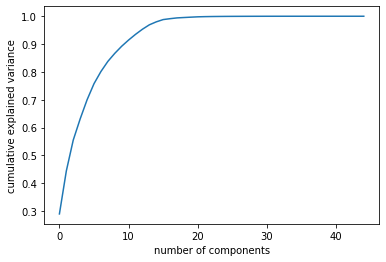

In [10]:
#PCA to minimize multicollinearity
pca = PCA().fit(df[list(feature_cols)])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

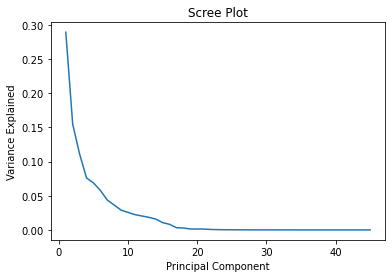

In [11]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [12]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = df[list(non_feature_cols)].copy()

df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,-4.191760,-2.608205,1.864478,0.694952,-0.526055,-1.879243,-3.027443,1.164236,-2.581055,0.486824,...,-2.295215,-1.052224,-0.897407,-0.223550,-0.162493,-0.179098,-0.087740,0.307439,20000711,2.0
1,0.920130,-2.146417,-2.458590,1.155902,-1.752429,-0.439910,1.115492,-0.658455,-0.414046,-1.107559,...,-0.301659,-1.536464,-0.904981,0.126223,0.038269,-0.194324,0.244327,-0.063214,20000721,21.0
2,-1.169598,1.460384,-3.122518,-0.731019,0.847428,-0.322921,2.664228,0.339560,0.568556,-0.661272,...,-1.839692,-0.356999,-0.870789,0.032722,-0.583721,-0.005373,0.016921,-0.060992,20000726,19.0
3,-1.349342,3.833427,-0.252943,-3.153443,1.881603,3.830571,1.911361,0.052289,-0.665210,-0.219027,...,0.625347,0.999099,-0.472899,1.071523,-0.027326,0.172346,-0.087367,-0.139240,20000729,-7.0
4,-1.633227,0.285636,-0.704053,-0.547860,-0.779714,1.704825,2.296978,0.533048,1.159765,-0.956665,...,-0.124854,-0.561451,-1.021661,-0.839614,0.257138,0.359876,-0.039135,-0.186703,20000734,-20.0


In [13]:
#split pca data into train and test
test_ids_set = set(test_spreads_df['GAME_ID'])

train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

train_game_ids = train_pca['GAME_ID'].copy()
test_game_ids = test_pca['GAME_ID'].copy()

y_train_pca = train_pca['SPREAD']
X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])

y_test_pca = test_pca['SPREAD']
X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-4.191760,-2.608205,1.864478,0.694952,-0.526055,-1.879243,-3.027443,1.164236,-2.581055,0.486824,-2.129565,-0.244205,-2.295215,-1.052224,-0.897407,-0.223550,-0.162493,-0.179098,-0.087740,0.307439
1,0.920130,-2.146417,-2.458590,1.155902,-1.752429,-0.439910,1.115492,-0.658455,-0.414046,-1.107559,0.249378,-0.821571,-0.301659,-1.536464,-0.904981,0.126223,0.038269,-0.194324,0.244327,-0.063214
2,-1.169598,1.460384,-3.122518,-0.731019,0.847428,-0.322921,2.664228,0.339560,0.568556,-0.661272,0.403651,-0.248648,-1.839692,-0.356999,-0.870789,0.032722,-0.583721,-0.005373,0.016921,-0.060992
3,-1.349342,3.833427,-0.252943,-3.153443,1.881603,3.830571,1.911361,0.052289,-0.665210,-0.219027,1.271762,0.575203,0.625347,0.999099,-0.472899,1.071523,-0.027326,0.172346,-0.087367,-0.139240
4,-1.633227,0.285636,-0.704053,-0.547860,-0.779714,1.704825,2.296978,0.533048,1.159765,-0.956665,1.130386,0.272306,-0.124854,-0.561451,-1.021661,-0.839614,0.257138,0.359876,-0.039135,-0.186703


## Baseline Model Implementation

In this section, I experiment with several ML models to get a sense of which models seem to be able to extract the most information from our data.

Win percentage:  0.6216216216216216
Percent of bets placed:  0.012032729022942404
Profit:  127.35270542354718
ROI:  3.245090180784906


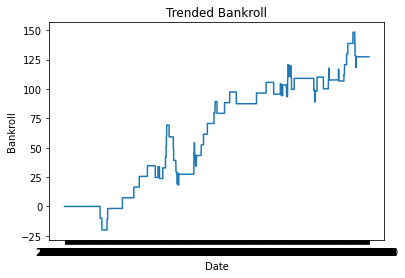

In [23]:
#linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train_pca)

eval_winnings(lin_reg, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.6111111111111112
Percent of bets placed:  0.01459971121450345
Profit:  137.22283529367706
ROI:  3.5740945097892354


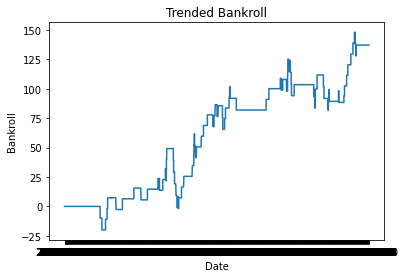

In [22]:
#polynomial regression
#tested with degree=3 as well which yielded poor results
degree = 2
poly=PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.fit_transform(X_test_pca)
poly_reg = LinearRegression()

poly_reg.fit(X_train_poly, y_train_pca)

eval_winnings(poly_reg, X_test_poly, test_ids_set, confidence_threshold=20, bet_amt=10)


Win percentage:  0.5538461538461539
Percent of bets placed:  0.010588801540189315
Profit:  35.86742403826578
ROI:  -0.24126602995976243


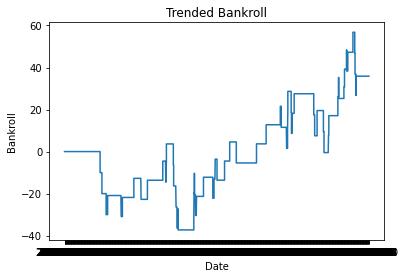

In [32]:
#SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train_pca, y_train_pca)

eval_winnings(sgd, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.5625
Percent of bets placed:  0.01315578373175036
Profit:  57.220853318660815
ROI:  -0.2324031871886964


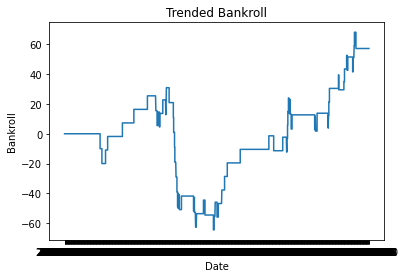

In [24]:
#Random Forrest implementation

rf = RandomForestRegressor()
rf.fit(X_train_pca, y_train_pca)

eval_winnings(rf, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.5769230769230769
Percent of bets placed:  0.02117760308037863
Profit:  125.30519575805874
ROI:  3.3030971585894298


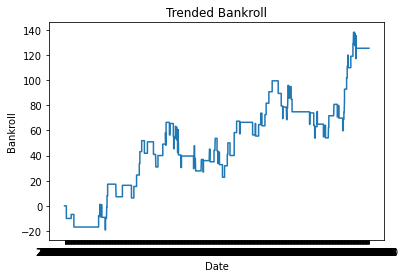

In [25]:
#xgboost
xgb = XGBRegressor()

xgb.fit(X_train_pca, y_train_pca)

eval_winnings(xgb, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.514018691588785
Percent of bets placed:  0.03465425958607412
Profit:  -77.86538490162943
ROI:  -1.5714158019383435


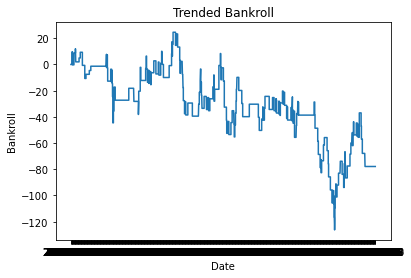

In [26]:
#KNN
knn = KNeighborsRegressor()
knn.fit(X_train_pca, y_train_pca)

eval_winnings(knn, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

## Model Tuning

Since linear regression performed best with polynomial features, we will begin by tuning the polynomial regression model by introducing an l2 penalty term.

Win percentage:  0.5934065934065934
Percent of bets placed:  0.014760147601476014
Profit:  117.5180922106731
ROI:  2.91726974035577


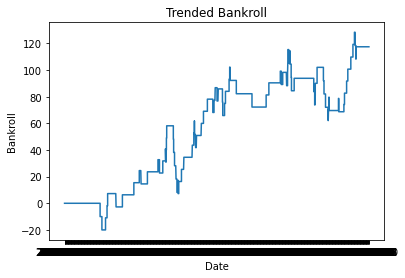

In [41]:
#Ridge Regresssion (Polynomial regression tuning)

#define parameter values to use for tuning
alpha_vals = [100, 10, 1, 0.01, 0.001, 0.0001]
grid = {'alpha': alpha_vals}

#tune using specified hyperparameters
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, grid, cv=5)
ridge_grid.fit(X_train_poly, y_train_pca)

ridge_tuned = ridge_grid.best_estimator_

#evaluate tuned model
eval_winnings(ridge_tuned, X_test_poly, test_ids_set, confidence_threshold=20, bet_amt=10)

In [40]:
ridge_tuned.best_params_

{'alpha': 100}

In [19]:
#implement ridge regression
#ridge regression did not significantly improve performance of baseline linear regression
'''
ridge_reg = Ridge()
alpha = np.logspace(1e-5, 1, 100)
grid = {'alpha' : alpha}

ridge_reg = GridSearchCV(estimator=ridge_reg, param_grid=grid, cv=5, verbose=5)
ridge_reg.fit(X_train_poly, y_train_pca)
print('Best score: ', ridge_reg.best_score_)
'''

"\nridge_reg = Ridge()\nalpha = np.logspace(1e-5, 1, 100)\ngrid = {'alpha' : alpha}\n\nridge_reg = GridSearchCV(estimator=ridge_reg, param_grid=grid, cv=5, verbose=5)\nridge_reg.fit(X_train_poly, y_train_pca)\nprint('Best score: ', ridge_reg.best_score_)\n"

In [20]:
#Tuned RF
#create hyperparameter grid

'''
rf = RandomForestRegressor()
n_estimators = [int(x) for x inn np.linspace(50, 500, num=10)]
max_features =['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=10, random_state=31, n_jobs=-1)

rf_random.fit(X_train, y_train)
'''

"\nrf = RandomForestRegressor()\nn_estimators = [int(x) for x inn np.linspace(50, 500, num=10)]\nmax_features =['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 50, num=10)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 5]\nbootstrap = [True, False]\n\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\n\nrf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=10, random_state=31, n_jobs=-1)\n\nrf_random.fit(X_train, y_train)\n"